# Analysis and preparation of smart meter data for further analysis
> Gerald Cuder  
> 22.02.2019  

In this notebook, the raw version of the dataset is analyzed and processed. 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import missingno as msn
import random

import matplotlib.pyplot as plt
import seaborn as sns

# Plot options
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn')
%matplotlib inline

# Other options
warnings.filterwarnings('ignore')

/home/gcuder/anaconda3/envs/smartmeter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gcuder/anaconda3/envs/smartmeter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gcuder/anaconda3/envs/smartmeter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Preprocessing

### Load data

In [2]:
%%time
df = pd.read_csv('../data/raw/Power-Networks-LCL-June2015(withAcornGps)v2.csv', parse_dates=['DateTime'])
df.head()

CPU times: user 2min 58s, sys: 7.71 s, total: 3min 6s
Wall time: 3min 23s


### Inspect data

In [3]:
df.describe()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
count,167932474,167932474,167932474,167932474,167932474,167932474
unique,5566,2,40405,7527,19,5
top,MAC000147,Std,2012-11-20 00:00:00,0,ACORN-E,Affluent
freq,39752,134148703,11062,2002920,48930543,67359986
first,NaN,NaN,2011-11-23 09:00:00,NaN,NaN,NaN
last,NaN,NaN,2014-02-28 00:00:00,NaN,NaN,NaN


### Drop obsolete information

In [4]:
df.drop(['Acorn', 'Acorn_grouped'], axis=1, inplace=True)
df.columns = ['LCLid', 'stdorToU', 'DateTime', 'consumption']
df.head()

,LCLid,stdorToU,DateTime,consumption
0,MAC000002,Std,2012-10-12 00:30:00,0
1,MAC000002,Std,2012-10-12 01:00:00,0
2,MAC000002,Std,2012-10-12 01:30:00,0
3,MAC000002,Std,2012-10-12 02:00:00,0
4,MAC000002,Std,2012-10-12 02:30:00,0


### Change column type

In [5]:
df['consumption'] = df['consumption'].convert_objects(convert_numeric=True)
df.describe()

,consumption
count,1.679269e+08
mean,2.117630e-01
std,2.972592e-01
min,0.000000e+00
25%,5.800000e-02
50%,1.170000e-01
75%,2.390000e-01
max,1.076100e+01


### Missing values

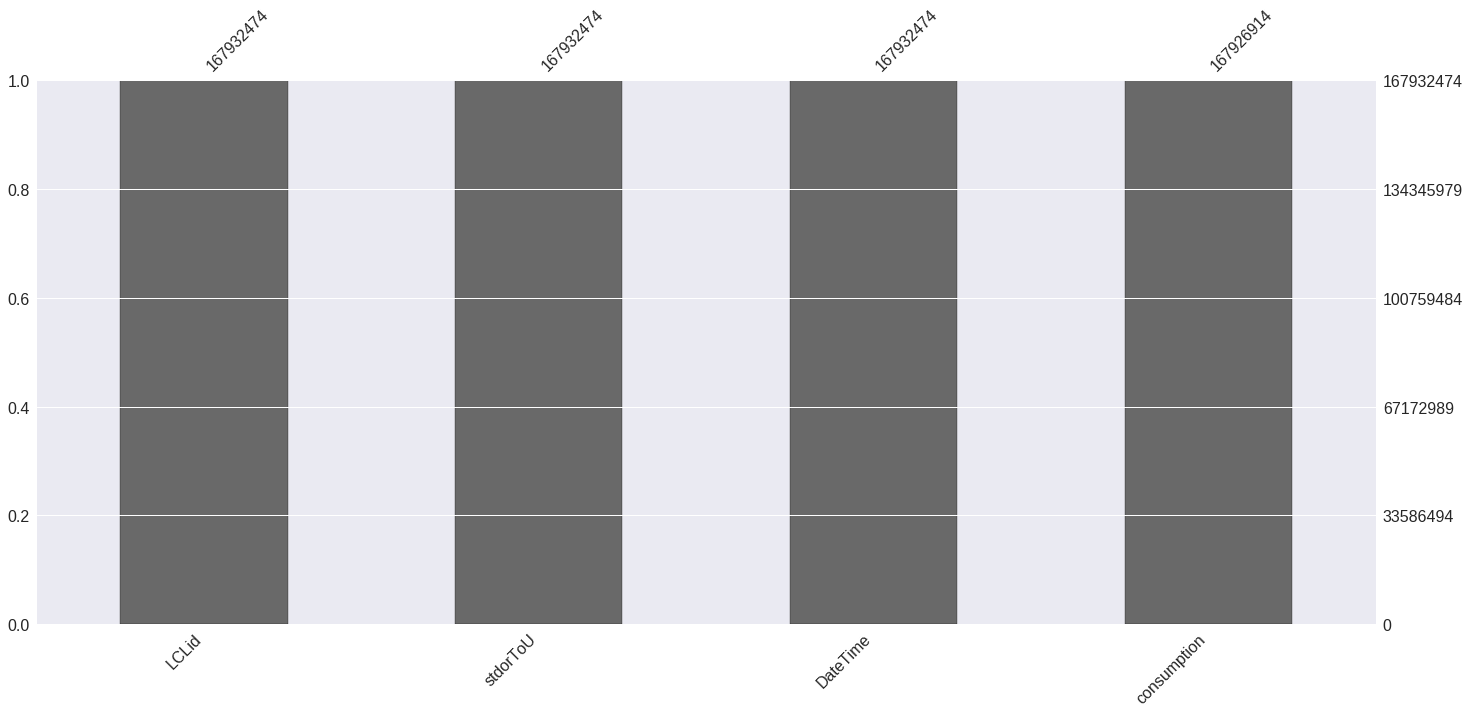

In [6]:
msn.bar(df)

### Subsetting data to deal with out of memory exception

In [7]:
household_sample = random.choices(df.LCLid.unique(), k=2000)
df_sub = df[df.LCLid.isin(household_sample)]

## Visualizing daily load patterns

###  Whole time range per household

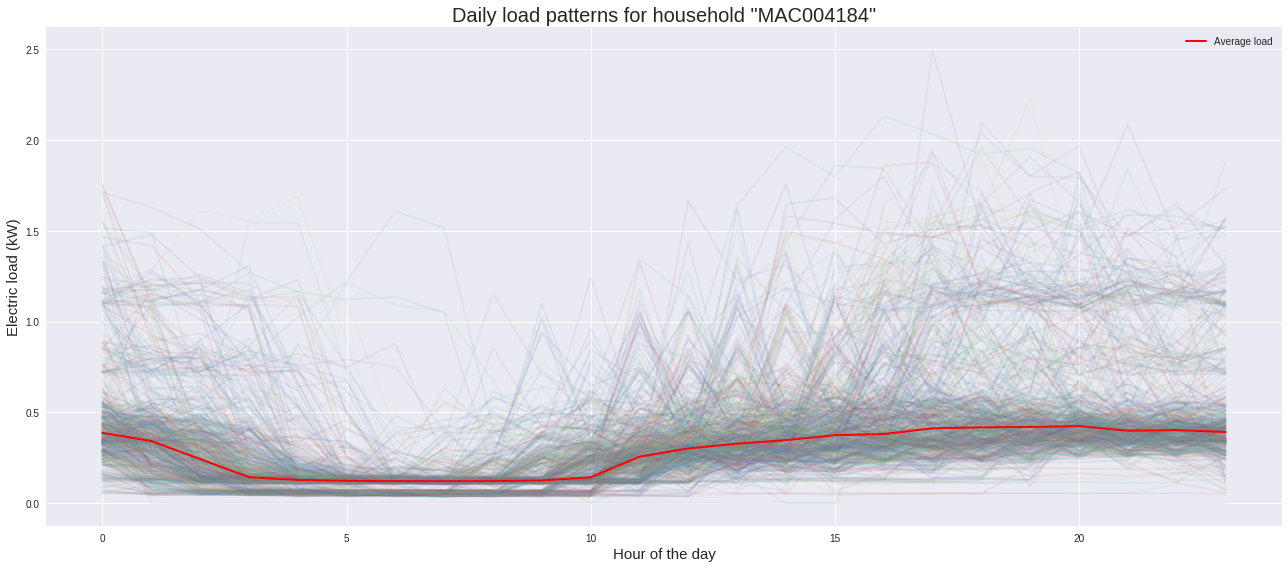

In [8]:
# Draw a random sample household
household_sample = random.choice(df.LCLid.unique())
df_sample = df[df.LCLid == household_sample]
df_sample.set_index('DateTime', inplace=True)
df_sample.drop(['LCLid', 'stdorToU'], 1, inplace=True)


# Resampling to hour
df_sample_hour = df_sample.resample('H').sum()

# Extracting necessary variables
df_sample_hour.reset_index(inplace=True)
df_sample_hour['date'] = df_sample_hour['DateTime'].apply(lambda x: x.date())
df_sample_hour['hour'] = df_sample_hour['DateTime'].apply(lambda x: x.hour)

# Long to wide for plotting
df_sample_daily_pattern = df_sample_hour.pivot_table(index='date', columns='hour', values='consumption')

# Plot
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(df_sample_daily_pattern.T, alpha=0.1)
ax.plot(df_sample_daily_pattern.median(), c='red', linewidth = 2, label = 'Average load')
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (kW)', size=15)
ax.set_title('Daily load patterns for household "{house}"'.format(house=household_sample), size=20)
ax.legend()
fig.tight_layout()
plt.savefig('../reports/figures/daily_patterns/' + household_sample + '.png')

###  Only the last full year per household (=2013)

In [17]:
df_sub.set_index('DateTime', inplace=True)
df_2013 = df_sub.loc['2013']

KeyError: 'DateTime'

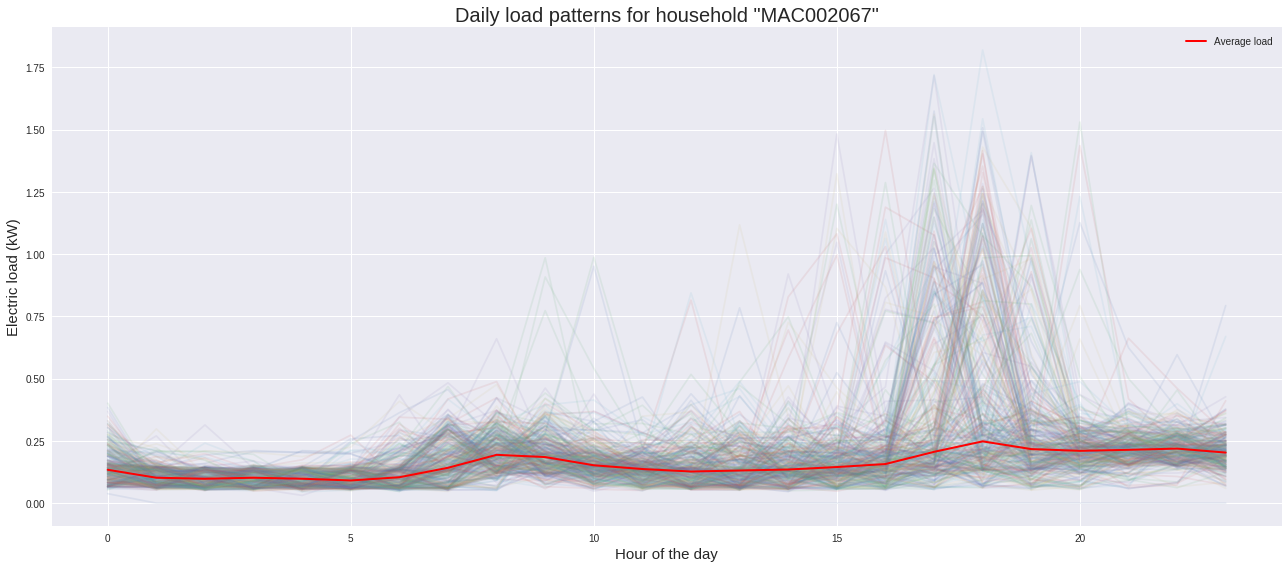

In [62]:
# Draw a random sample household
household_sample = random.choice(df_2013.LCLid.unique())
df_sample = df_2013[df_2013.LCLid == household_sample]
df_sample.set_index('DateTime', inplace=True)
df_sample.drop(['LCLid', 'stdorToU'], 1, inplace=True)


# Resampling to hour
df_sample_hour = df_sample.resample('H').sum()

# Extracting necessary variables
df_sample_hour.reset_index(inplace=True)
df_sample_hour['date'] = df_sample_hour['DateTime'].apply(lambda x: x.date())
df_sample_hour['hour'] = df_sample_hour['DateTime'].apply(lambda x: x.hour)

# Long to wide for plotting
df_sample_daily_pattern = df_sample_hour.pivot_table(index='date', columns='hour', values='consumption')

# Plot
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(df_sample_daily_pattern.T, alpha=0.1)
ax.plot(df_sample_daily_pattern.median(), c='red', linewidth = 2, label = 'Average load')
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (kW)', size=15)
ax.set_title('Daily load patterns for household "{house}"'.format(house=household_sample), size=20)
ax.legend()
fig.tight_layout()

### Sample mean of all households over the day

In [21]:
df_2013.reset_index(inplace=True)
df_2013['date'] = df_2013['DateTime'].apply(lambda x: x.date())
df_2013['time'] = df_2013['DateTime'].apply(lambda x: x.time())

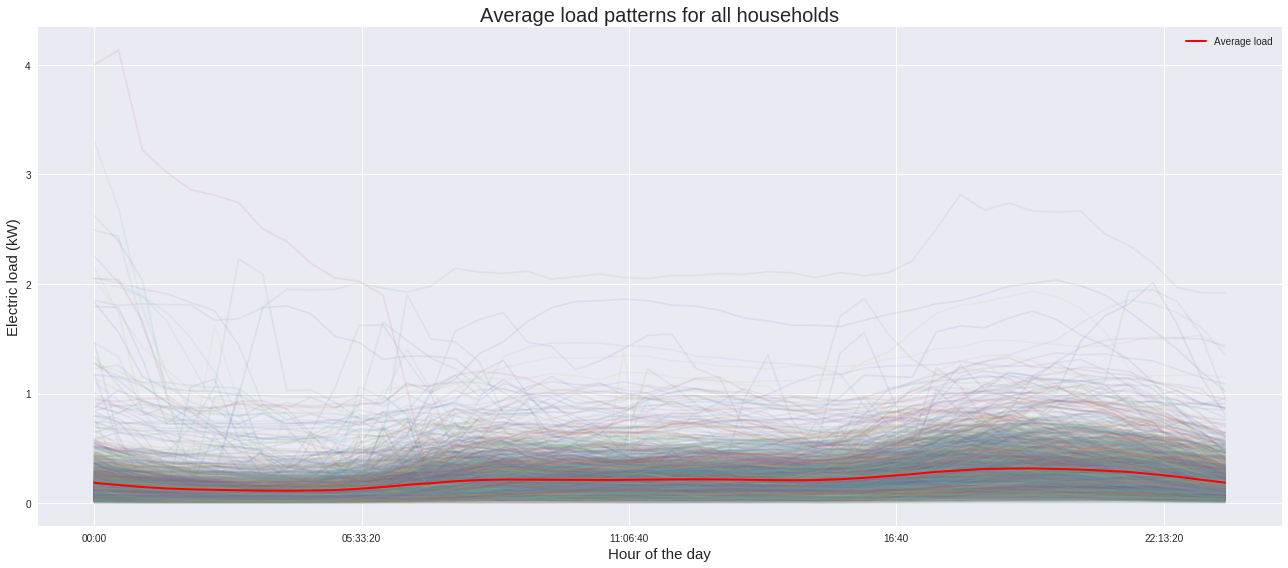

In [60]:

df_2013_median = df_2013.groupby(['LCLid', 'time'])['consumption'].mean().reset_index(name='median_load')
df_plot = df_2013_median.pivot_table(index='time', columns='LCLid', values='median_load')

# Plot
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(df_plot, alpha=0.1)
ax.plot(df_plot.T.mean(), c='red', linewidth = 2, label = 'Average load')
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (kW)', size=15)
ax.set_title('Average load patterns for all households', size=20)
ax.legend()
fig.tight_layout()

## Export data

In [64]:
df_2013.to_csv('../data/processed/london_2013.csv', index=False)